In [1]:
# Setting the PythonPath
import os
import sys

# # Get the parent directory of the current working directory
parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
if "changed" not in locals():
    changed = False

if not changed:
    os.chdir(parent_dir)
    changed = True
print(os.getcwd())

/home/local/USHERBROOKE/aara2601/projects/qombating-fires


## Get data

In [56]:
from bassir.utils.settings import EXPERIMENTS_PATH, TRAIN_CONFIGS_PATH, STORAGE_PATH
from bassir.utils.loading.data_loaders import get_data_loaders
from bassir.prep.temporal_prep import WildfireWindowDataset

# Now you can access your config fields, e.g.:

train_loader, _, test_loader = get_data_loaders(cfg.data)            
dataset_object_path = os.path.join(STORAGE_PATH, "dataset", cfg.data.name, "preprocessed_dataset.pkl")
dataset = WildfireWindowDataset.load(dataset_object_path)

### Prepare test samples

In [46]:
from torch.utils.data import DataLoader
X_agg_test_samples, y_test_samples = torch.as_tensor(dataset.X_agg_test_samples), torch.as_tensor(dataset.y_test_samples)
n_cells = X_agg_test_samples.size(0) // dataset.window_size

X_agg_test_samples = X_agg_test_samples.reshape(dataset.window_size, n_cells, X_agg_test_samples.size(-1))
y_test_samples = y_test_samples.reshape(dataset.window_size, n_cells)

X_agg_test_samples.shape, y_test_samples.shape

(torch.Size([7, 1396, 104]), torch.Size([7, 1396]))

## Retrieve model

In [47]:
import torch
from bassir.utils.settings import EXPERIMENTS_PATH
from omegaconf import OmegaConf
from bassir.utils.build import get_lightning_model

# 0) Get paths
run_dir = os.path.join(EXPERIMENTS_PATH, "wildfires", "approximate_gp", "embed_bassir", "2025-03-09_00_20_00")
best_ckpt_path = os.path.join(run_dir, "epoch=87-val_acc=0.68.ckpt")
cfg_path = os.path.join(run_dir, ".hydra", "config.yaml")

# Load the config
cfg = OmegaConf.load(cfg_path)

# 1) Instantiate the same model architecture
lightning_model = get_lightning_model(cfg=cfg.model, train_loader=train_loader)

# 2) Load the checkpoint dictionary
ckpt = torch.load(best_ckpt_path, map_location="cpu")

# 3) Load the model’s parameters from the checkpoint
lightning_model.load_state_dict(ckpt["state_dict"])

# 4) Set the model to evaluation mode & freeze parameters if desired
lightning_model.eval()
lightning_model.freeze()

/tmp/ipykernel_737587/4140961286.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_ckpt_path, map_location="cpu")


### Used model

In [48]:
lightning_model

ApproxLightningGP(
  (gp_model): ApproximateGP(
    (variational_strategy): VariationalStrategy(
      (_variational_distribution): NaturalVariationalDistribution()
    )
    (mean_module): ZeroMean()
    (covar_module): EmbedBassirKernel(
      (embedder): SimpleEmbedder(
        (embedding_layer): Sequential(
          (0): Linear(in_features=104, out_features=69, bias=True)
          (1): ReLU()
          (2): Linear(in_features=69, out_features=34, bias=True)
        )
      )
      (positioner): Positioner(
        (projector): Sequential(
          (0): Linear(in_features=34, out_features=20, bias=True)
          (1): ReLU()
          (2): Linear(in_features=20, out_features=6, bias=True)
        )
      )
      (evolver): RydbergEvolver(
        (varyer): Sequential(
          (0): Linear(in_features=34, out_features=19, bias=True)
          (1): ReLU()
          (2): Linear(in_features=19, out_features=4, bias=True)
        )
      )
    )
  )
  (likelihood): PGLikelihood(
    

### Used register

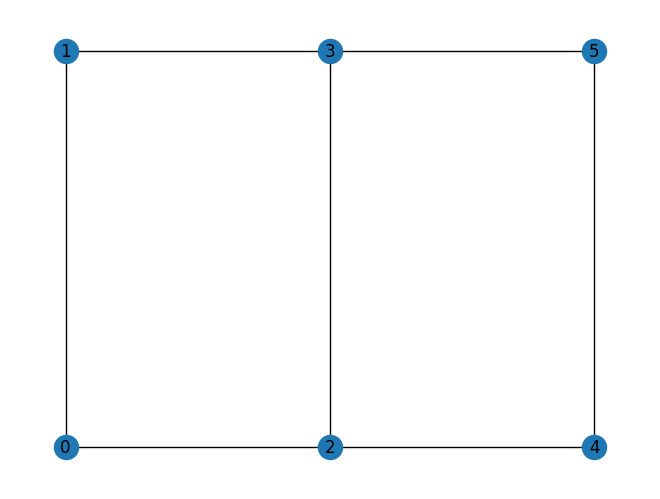

In [110]:
# Draw the register without immediately showing the plot
reg.draw(show=False)

# Get the current figure from matplotlib
fig = plt.gcf()

reg_path = os.path.join(run_dir, "plots", "register.pdf")
# Save it as a PDF
fig.savefig(reg_path, format="pdf")

# Optionally, display it
plt.show()

### Compute test samples outputs

In [55]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    lightning_model.to(DEVICE)
    lightning_model.eval()

    probabilities = []
    for i in range(dataset.window_size):
        post_dist = lightning_model.likelihood(lightning_model(X_agg_test_samples[i].to(DEVICE)))
        probs_i = post_dist.probs.cpu().numpy()  # now won't require .detach()
        probabilities.append(probs_i)
    
    # Concatenate all days along axis 0 to get a single 1D array
    probabilities = np.concatenate(probabilities, axis=0)  # shape: (window_size * n_cells,)

    out_csv_path = os.path.join(STORAGE_PATH, "output", f"test_samples_predictions_{cfg.model.kernel.name}.csv")
    os.makedirs(os.path.dirname(out_csv_path), exist_ok=True)
    csv_df = dataset.produce_test_csv(probabilities=probabilities, out_csv_path=out_csv_path)
csv_df.DATE.unique()

array(['2020-05-17', '2020-05-18', '2020-05-19', '2020-05-20',
       '2020-05-21', '2020-05-22', '2020-05-23'], dtype=object)

# Results

## General classification plots

In [57]:
# Suppose 'lightning_model' is your loaded GP model,
# and 'test_loader' is your DataLoader for the test set.
from bassir.view.viewing3 import gather_gp_inference_data

y_true, y_pred_probs, y_pred_vars = gather_gp_inference_data(lightning_model, test_loader, device=DEVICE)

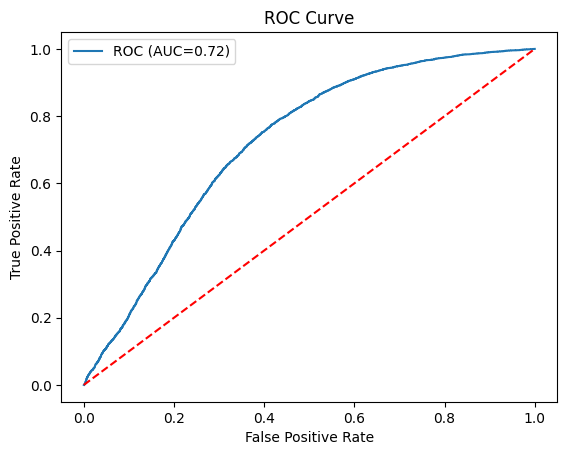

In [52]:
from bassir.view.viewing import plot_roc_curve
_ = plot_roc_curve(y_true, y_pred_probs)

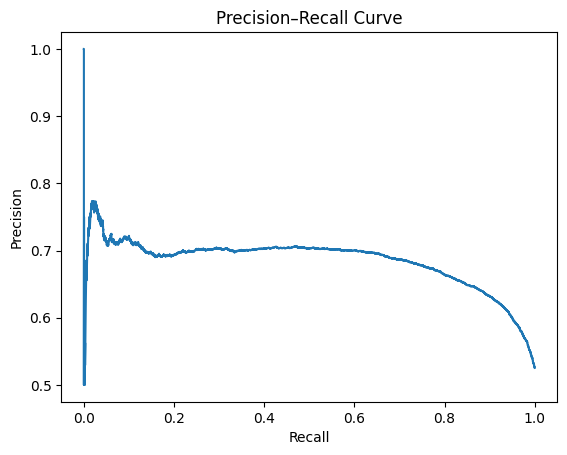

In [53]:
from bassir.view.viewing import plot_precision_recall_curve
_ = plot_precision_recall_curve(y_true, y_pred_probs)

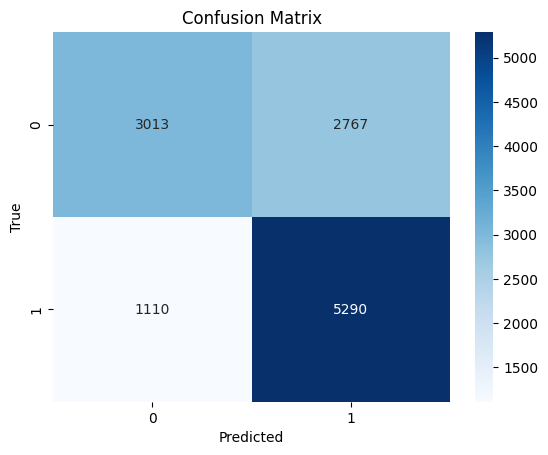

In [55]:
from bassir.view.viewing import plot_confusion_matrix
_ = plot_confusion_matrix(y_true, y_pred_probs, threshold=0.5)

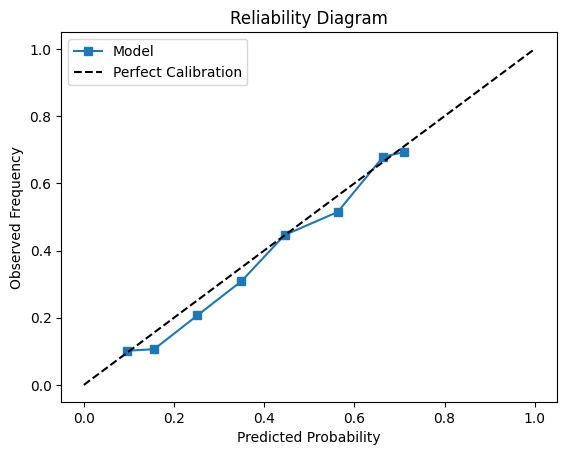

In [58]:
from bassir.view.viewing import plot_calibration_diagram
_ = plot_calibration_diagram(y_true, y_pred_probs, n_bins=10)

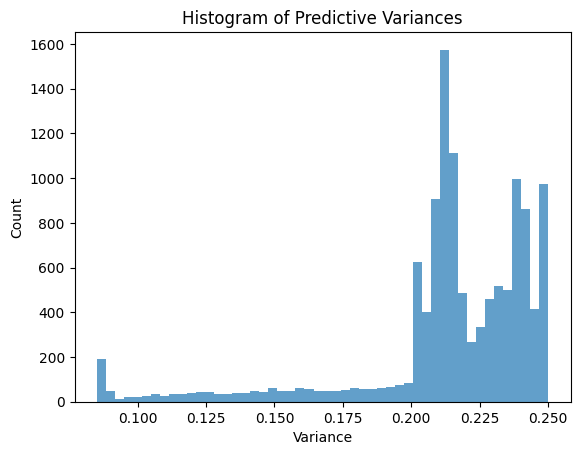

In [60]:
from bassir.view.viewing import plot_variance_histogram
_ = plot_variance_histogram(y_pred_vars)

In [82]:
import importlib
import bassir

importlib.reload(bassir.view.viewing3)

<module 'bassir.view.viewing3' from '/home/local/USHERBROOKE/aara2601/projects/qombating-fires/bassir/view/viewing3.py'>

In [80]:
from bassir.view.viewing import gather_gp_inference_data

y_true, y_pred_probs, y_pred_vars = gather_gp_inference_data(lightning_model, test_loader, device=DEVICE)

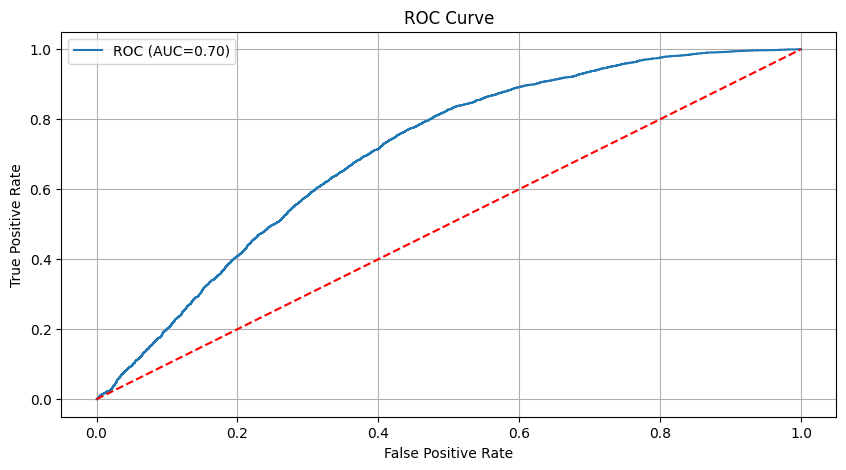

In [84]:
from bassir.view.viewing3 import plot_roc_curve2
plots_dir = os.path.join(run_dir, "plots")
save_path = os.path.join(plots_dir, "roc_curve.pdf")
os.makedirs(plots_dir, exist_ok=True)

_ = plot_roc_curve(y_true, y_pred_probs, show=True, save_path=save_path)

In [ ]:
save_path = os.path.join(plots_dir, "roc_curve.pdf")